##Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

##Load and preprocess data

Use the Fashion MNIST dataset using tensorflow datasets

This dataset has 28x28 grayscale images of articles of clothing belonging to 10 classes

In [2]:
#Get the data and process the data
train_data = tfds.load('fashion_mnist' , split='train')
test_data  = tfds.load('fashion_mnist' , split="test")

class_names = ['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteQZ4TLI/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteQZ4TLI/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Normalize the image by dividing them by 255.0 so as to make the pizels fall in the range (0, 1). Also reshape the data so as to flatten the 28x28 pixel array into a flattened 784 pixel array.

In [3]:
def format_image(data):
  image = data['image']
  image = tf.reshape(image, [-1])
  image = tf.cast(image, 'float32')
  image = image / 255.0
  return image, data['label']

In [4]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

Shuffle and batch the training and test datasets before feeding them to the model

In [5]:
batch_size = 64

train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test = test_data.batch(batch_size=batch_size)

##Define the model

Use the Keras functional API to connect two dense layers 

The final layer is a softmax that outputs one of the 10 classes since this is a multi-class classification problem

In [6]:
def base_model():
  inputs = Input(shape=(784,), name='digits')

  x = Dense(64, activation='relu', name='dense_1')(inputs)
  x = Dense(64, activation='relu', name='dense_2')(x)

  outputs = Dense(10, activation='softmax', name='predictions')(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model

##Define optimizer and loss function

Use `adam` as the optimizer and `sparse_categorical_crossentropy` for the loss

In [7]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

##Define metrics 

Define metrics so that the training loop can update and display them. Use SparseCategoricalAccuracy defined in tf.keras.metrics sinc ethe problem at hand is a multi-class classification problem

In [8]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

##Building the Training Loop

The training loop consists of training and validation sequences. 

The core of training is using the model to calculate the logits (predicitons) on a specific set of inputs and compute the loss (in this case `sparse categorical cross entropy`) by comparing the predicted outputs to the true outputs. 

After that, update the trainable weights using the optimizer algorithim chosen. 

The optimizer algorithm requires the  computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same. 

Use gradient tape to calculate the gradients and then update the model's trainable parameters / weights using the optimizer.

In [17]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    #logits are predictions of the model at a given time 
    logits = model(x)
    loss_value = loss(y_true=y, y_pred=logits)

  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  return logits, loss_value

The function below performs training for one epoch. 

Run through all batches of training data in each epoch to make updates to trainable weights using the previous function.

Notice that `update_state` is also called on the metrics to accumulate values of the metrics.

A progress bar is being displayed to indicate completion of training in each epoch (use tqdm for this)

In [21]:
def train_data_for_one_epoch():
  losses = []

  for step, (x_batch_train, y_batch_train) in enumerate(train):
    logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)

    losses.append(loss_value)

    train_acc_metric(y_batch_train, logits)

  return losses

At the end of each epoch, validate the modle onthe test dataset. The following function calculates the loss on test dataset and updates the states of the validation metrics.

In [18]:
def perform_validation():
  losses = []

  for x_val, y_val in test:
    val_logits = model(x_val)
    val_loss = loss(y_true = y_val, y_pred = val_logits)

    losses.append(val_loss)
    val_acc_metric(y_val, val_logits)

  return losses


Next define the training loop that runs through the training smaples repeatedly over a fixed number of epochs. 

Combine the functions build earlier to establish the following flow:
1. Perform training over all batches of training data
2. Get values of metrics
3. Perform validation to calculate loss and update validation metrics on test data
4. Reset the metrics at the end of epoch
5. Display statistics at the end of each epoch

NOTE: Also calculate the training and validation losses for the whole epoch at the end of the epoch

In [22]:
model = base_model()

#Iterate over epochs
epochs = 10
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)

  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(np.mean(losses_train_mean)), float(np.mean(losses_val_mean)), float(train_acc), float(val_acc)))

  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

Start of epoch 0

 Epoch 0: Train loss: 0.4863  Validation Loss: 0.4336, Train Accuracy: 0.8261, Validation Accuracy 0.8407
Start of epoch 1

 Epoch 1: Train loss: 0.3706  Validation Loss: 0.3959, Train Accuracy: 0.8650, Validation Accuracy 0.8589
Start of epoch 2

 Epoch 2: Train loss: 0.3368  Validation Loss: 0.3712, Train Accuracy: 0.8758, Validation Accuracy 0.8680
Start of epoch 3

 Epoch 3: Train loss: 0.3174  Validation Loss: 0.3774, Train Accuracy: 0.8824, Validation Accuracy 0.8660
Start of epoch 4

 Epoch 4: Train loss: 0.3026  Validation Loss: 0.3673, Train Accuracy: 0.8878, Validation Accuracy 0.8709
Start of epoch 5

 Epoch 5: Train loss: 0.2909  Validation Loss: 0.3451, Train Accuracy: 0.8922, Validation Accuracy 0.8759
Start of epoch 6

 Epoch 6: Train loss: 0.2772  Validation Loss: 0.3473, Train Accuracy: 0.8973, Validation Accuracy 0.8770
Start of epoch 7

 Epoch 7: Train loss: 0.2725  Validation Loss: 0.3404, Train Accuracy: 0.8982, Validation Accuracy 0.8766
Start of

##Evaluate the Model

##Plots for Evaluation

Plot the progress of loss as training proceeds over number of epochs

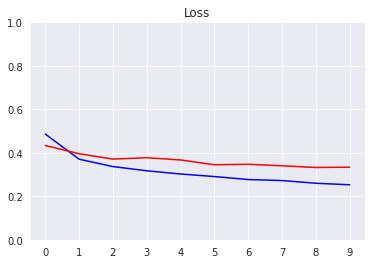

In [24]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0, ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric, color='blue', label=metric_name)
  plt.plot(val_metric, color='red', label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, 'Loss', "Loss", ylim=1.0)